In [9]:
import os
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import xgboost as xgb
import joblib
print('Imports OK')

Imports OK


In [12]:
class VoiceVerificationPipeline:
    """End-to-end pipeline for feature engineering, training and evaluation.

    This version is defensive: it filters out non-numeric columns (e.g. audio path strings)
    before attempting to convert to float so string metadata does not cause crashes.
    """
    def __init__(self, features_path: str = 'features_audio/audio_features_all.csv'):
        from pathlib import Path
        self.features_path = Path(features_path)
        self.models = {}
        self.scaler = None
        self.feature_selector = None
        self.final_features = None
        self.person_le = None
        self.phrase_le = None

    def load_data(self):
        import pandas as pd
        if not self.features_path.exists():
            raise FileNotFoundError(f'Features file not found: {self.features_path}')
        df = pd.read_csv(self.features_path)
        # Expect `person` and `phrase` columns
        if 'person' not in df.columns or 'phrase' not in df.columns:
            raise ValueError('Merged CSV must contain `person` and `phrase` columns')
        self.df = df
        return df

    def feature_engineering(self, initial_feature_cols=None, var_thresh=1e-6, corr_thresh=0.95, k_features=60):
        import numpy as np
        import pandas as pd
        from sklearn.feature_selection import VarianceThreshold, SelectKBest, f_classif

        # Determine initial feature columns if not provided
        if initial_feature_cols is None:
            initial_feature_cols = [c for c in self.df.columns if c not in ['person', 'phrase']]

        # Defensive: keep only columns that can be converted to numeric reliably
        numeric_cols = []
        for c in initial_feature_cols:
            # try to coerce to numeric; treat a column as numeric if >90% values convert
            coerced = pd.to_numeric(self.df[c], errors='coerce')
            nonnull_frac = coerced.notnull().mean()
            if nonnull_frac >= 0.9:
                numeric_cols.append(c)
        if len(numeric_cols) == 0:
            raise ValueError('No numeric feature columns found. Check feature_columns.txt and merged CSV for unexpected string columns.')

        X = self.df[numeric_cols].astype(float).fillna(0)

        # 1) variance threshold
        vt = VarianceThreshold(threshold=var_thresh)
        X_v = vt.fit_transform(X)
        kept_after_var = [c for i, c in enumerate(numeric_cols) if vt.get_support()[i]]

        # 2) correlation pruning
        Xv_df = pd.DataFrame(X_v, columns=kept_after_var)
        corr = Xv_df.corr().abs()
        upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
        to_drop = [col for col in upper.columns if any(upper[col] > corr_thresh)]
        kept_after_corr = [c for c in kept_after_var if c not in to_drop]
        X_corr = Xv_df[kept_after_corr].values

        # 3) univariate selection
        K = min(k_features, X_corr.shape[1])
        if K < X_corr.shape[1]:
            skb = SelectKBest(score_func=f_classif, k=K)
            # use encoded person labels for scoring
            skb.fit(X_corr, self._encode_person(self.df['person']))
            sel_mask = skb.get_support()
            final_features = [f for i, f in enumerate(kept_after_corr) if sel_mask[i]]
            X_final = skb.transform(X_corr)
            self.feature_selector = skb
        else:
            final_features = kept_after_corr
            X_final = X_corr
            self.feature_selector = None

        self.final_features = final_features
        # return numeric matrix aligned to final_features
        return X_final

    def _encode_person(self, y):
        from sklearn.preprocessing import LabelEncoder
        if self.person_le is None:
            self.person_le = LabelEncoder().fit(y.astype(str))
        return self.person_le.transform(y.astype(str))

    def _encode_phrase(self, y):
        from sklearn.preprocessing import LabelEncoder
        if self.phrase_le is None:
            self.phrase_le = LabelEncoder().fit(y.astype(str))
        return self.phrase_le.transform(y.astype(str))

    def split_and_scale(self, X, y_person, test_size=0.2, random_state=42, stratify=None):
        from sklearn.model_selection import train_test_split
        from sklearn.preprocessing import StandardScaler
        X_train, X_test, y_train, y_test = train_test_split(X, y_person, test_size=test_size, random_state=random_state, stratify=stratify)
        scaler = StandardScaler().fit(X_train)
        X_train_s = scaler.transform(X_train)
        X_test_s = scaler.transform(X_test)
        self.scaler = scaler
        return X_train_s, X_test_s, y_train, y_test

    def train_random_forest(self, X_train, y_train, n_estimators=200):
        from sklearn.ensemble import RandomForestClassifier
        model = RandomForestClassifier(n_estimators=n_estimators, random_state=42, class_weight='balanced')
        model.fit(X_train, y_train)
        return model

    def evaluate(self, model, X_test, y_test, label_encoder=None):
        from sklearn.metrics import accuracy_score, f1_score, log_loss, classification_report, confusion_matrix
        res = {}
        y_pred = model.predict(X_test)
        res['accuracy'] = float(accuracy_score(y_test, y_pred))
        res['f1_macro'] = float(f1_score(y_test, y_pred, average='macro'))
        res['f1_weighted'] = float(f1_score(y_test, y_pred, average='weighted'))
        try:
            probs = model.predict_proba(X_test)
            res['log_loss'] = float(log_loss(y_test, probs))
        except Exception:
            res['log_loss'] = None
        res['report'] = classification_report(y_test, y_pred, output_dict=True)
        res['confusion_matrix'] = confusion_matrix(y_test, y_pred).tolist()
        return res

    def save_artifacts(self, out_dir='models'):
        import joblib, json, os
        out = os.path.abspath(out_dir)
        os.makedirs(out, exist_ok=True)
        # save final features
        with open(os.path.join(out, 'feature_columns.txt'), 'w', encoding='utf-8') as fh:
            fh.write('\n'.join(self.final_features))
        # save scaler
        if self.scaler is not None:
            joblib.dump(self.scaler, os.path.join(out, 'scaler.pkl'))
        # save label encoders
        if self.person_le is not None:
            joblib.dump(self.person_le, os.path.join(out, 'person_label_encoder.pkl'))
        if self.phrase_le is not None:
            joblib.dump(self.phrase_le, os.path.join(out, 'phrase_label_encoder.pkl'))
        # save models
        for name, obj in self.models.items():
            joblib.dump(obj, os.path.join(out, f'{name}.pkl'))
        # save metrics if present
        if hasattr(self, 'metrics'):
            with open(os.path.join(out, 'metrics.json'), 'w', encoding='utf-8') as fh:
                json.dump(self.metrics, fh, indent=2)
        return out

    def plot_confusion_matrix(self, cm, labels, title='Confusion matrix'):
        import matplotlib.pyplot as plt
        import seaborn as sns
        import numpy as np
        plt.figure(figsize=(6,5))
        sns.heatmap(cm, annot=True, fmt='d', xticklabels=labels, yticklabels=labels, cmap='Blues')
        plt.ylabel('True')
        plt.xlabel('Predicted')
        plt.title(title)
        plt.show()

    def run_all(self, test_size=0.2, random_state=42):
        import numpy as np
        # load
        self.load_data()
        # feature engineering (this filters non-numeric columns)
        X_final = self.feature_engineering()
        # encode labels
        y_person_enc = self._encode_person(self.df['person'])
        y_phrase_enc = self._encode_phrase(self.df['phrase'])
        # split and scale for speaker
        X_train_s, X_test_s, y_train_s, y_test_s = self.split_and_scale(X_final, y_person_enc, test_size=test_size, random_state=random_state, stratify=y_person_enc)
        # train speaker model
        sp_model = self.train_random_forest(X_train_s, y_train_s)
        sp_metrics = self.evaluate(sp_model, X_test_s, y_test_s, label_encoder=self.person_le)
        self.models['speaker_rf'] = sp_model
        self.metrics = {'speaker': sp_metrics}
        print('\nSpeaker metrics:', sp_metrics)
        # train phrase model (use same feature transforms)
        X_ph = X_final
        # split by phrase
        from sklearn.model_selection import train_test_split
        X_ph_train, X_ph_test, y_ph_train, y_ph_test = train_test_split(X_ph, y_phrase_enc, test_size=test_size, random_state=random_state, stratify=y_phrase_enc)
        # scale with scaler obtained from speaker split
        if self.scaler is not None:
            X_ph_train_s = self.scaler.transform(X_ph_train)
            X_ph_test_s = self.scaler.transform(X_ph_test)
        else:
            X_ph_train_s, X_ph_test_s = X_ph_train, X_ph_test
        ph_model = self.train_random_forest(X_ph_train_s, y_ph_train)
        ph_metrics = self.evaluate(ph_model, X_ph_test_s, y_ph_test, label_encoder=self.phrase_le)
        self.models['phrase_rf'] = ph_model
        self.metrics['phrase'] = ph_metrics
        print('\nPhrase metrics:', ph_metrics)
        # save artifacts
        saved = self.save_artifacts()
        # plot confusion matrices
        try:
            import numpy as np
            sp_cm = np.array(sp_metrics['confusion_matrix'])
            self.plot_confusion_matrix(sp_cm, labels=self.person_le.classes_, title='Speaker Confusion Matrix')
            ph_cm = np.array(ph_metrics['confusion_matrix'])
            self.plot_confusion_matrix(ph_cm, labels=self.phrase_le.classes_, title='Phrase Confusion Matrix')
        except Exception as e:
            print('Could not plot confusion matrices:', e)
        return saved


## Demo / Run training (only run if `data/processed/audio_features_all.csv` exists)
The following cell prepares data and trains all models. Training may take a while depending on dataset size.


Speaker metrics: {'accuracy': 1.0, 'f1_macro': 1.0, 'f1_weighted': 1.0, 'log_loss': 0.18135788253603566, 'report': {'0': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 3.0}, '1': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 4.0}, '2': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 3.0}, 'accuracy': 1.0, 'macro avg': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 10.0}, 'weighted avg': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 10.0}}, 'confusion_matrix': [[3, 0, 0], [0, 4, 0], [0, 0, 3]]}

Phrase metrics: {'accuracy': 0.8, 'f1_macro': 0.7916666666666667, 'f1_weighted': 0.7916666666666667, 'log_loss': 0.4262981634029737, 'report': {'0': {'precision': 0.7142857142857143, 'recall': 1.0, 'f1-score': 0.8333333333333334, 'support': 5.0}, '1': {'precision': 1.0, 'recall': 0.6, 'f1-score': 0.75, 'support': 5.0}, 'accuracy': 0.8, 'macro avg': {'precision': 0.8571428571428572, 'recall': 0.8, 'f1-score': 0.791666666

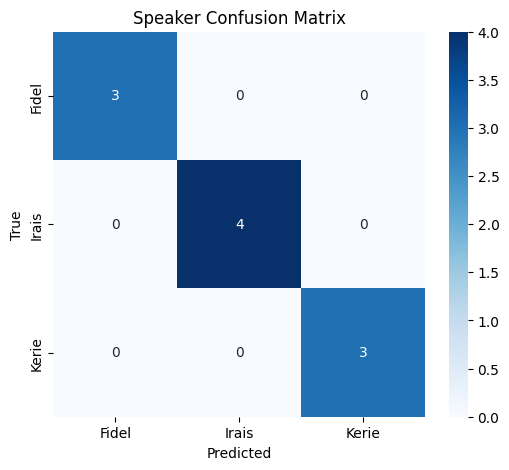

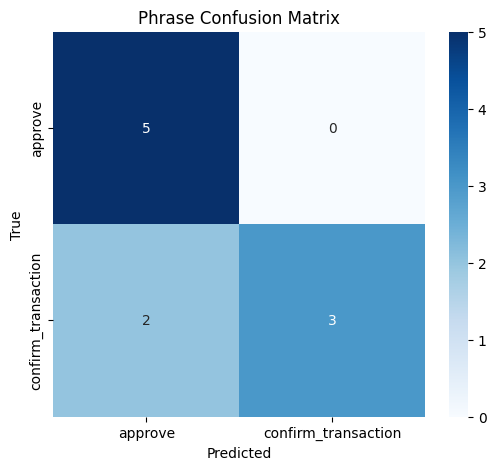

Artifacts saved to c:\Users\LENOVO\Documents\KERIE\ML_FORMATIVE2\Formative-2-Data-Preprocessing\models


In [13]:
# Demo: run the full pipeline end-to-end
try:
    pipe = VoiceVerificationPipeline(features_path='features_audio/audio_features_all.csv')
    saved_dir = pipe.run_all()
    print('Artifacts saved to', saved_dir)
except Exception as e:
    print('Pipeline run failed:', e)
    raise

In [ ]:
# Verification helper + small sample test
import joblib
import numpy as np
from pathlib import Path
MODELS_DIR = Path('models')

if not MODELS_DIR.exists():
    print('models/ not found - run the training pipeline first (run the pipeline demo cell).')
else:
    # load speaker model and encoders
    try:
        speaker_art = joblib.load(MODELS_DIR / 'speaker_rf.pkl')
    except Exception as e:
        raise RuntimeError('Failed to load speaker_rf.pkl from models/: ' + str(e))

    if isinstance(speaker_art, dict) and 'model' in speaker_art:
        speaker_model = speaker_art['model']
        person_le = speaker_art.get('le')
    else:
        speaker_model = speaker_art
        person_le = None
        if (MODELS_DIR / 'person_label_encoder.pkl').exists():
            person_le = joblib.load(MODELS_DIR / 'person_label_encoder.pkl')

    scaler = joblib.load(MODELS_DIR / 'scaler.pkl') if (MODELS_DIR / 'scaler.pkl').exists() else None
    feature_cols = [l.strip() for l in open(MODELS_DIR / 'feature_columns.txt','r',encoding='utf-8') if l.strip()] if (MODELS_DIR / 'feature_columns.txt').exists() else None

    # Import extractor (requirement for feature extraction). Try to import project extractor, otherwise fail clearly.
    try:
        from audio_feature_extraction import AudioFeatureExtractor
        extractor = AudioFeatureExtractor()
    except Exception as e:
        extractor = None
        print('Warning: could not import AudioFeatureExtractor:', e)
        print('If you want a quick demo without the project extractor, run the extraction notebook or ensure audio_feature_extraction.py is in the workspace.')

    def prepare_single(audio_path):
        if extractor is None:
            raise RuntimeError('AudioFeatureExtractor not available. Run audio extraction notebook or add audio_feature_extraction.py.')
        feats = extractor.extract_features(audio_path)
        if feats is None:
            raise ValueError('Feature extraction failed for: ' + str(audio_path))
        if feature_cols is None:
            raise RuntimeError('feature_columns.txt not found; run feature engineering/training to produce it.')
        row = [feats.get(c, 0.0) for c in feature_cols]
        X = scaler.transform([row]) if scaler is not None else np.array([row])
        return X

    def verify(audio_path, claimed_name, threshold=0.5):
        """Return Accept/Reject for claimed identity using model probability for claimed class.
        """
        X = prepare_single(audio_path)
        probs = speaker_model.predict_proba(X)[0]
        # determine index for claimed_name
        if person_le is not None:
            try:
                idx = int(person_le.transform([claimed_name])[0])
            except Exception:
                raise ValueError(f"Claimed name '{claimed_name}' not found in saved label encoder")
        else:
            # fallback: model.classes_
            classes = list(speaker_model.classes_)
            if claimed_name not in classes:
                raise ValueError(f"Claimed name '{claimed_name}' not in model classes: {classes}")
            idx = classes.index(claimed_name)
        score = float(probs[idx])
        accept = score >= threshold
        return {'claimed': claimed_name, 'score': score, 'accept': accept}

    print('verify(audio_path, claimed_name, threshold=0.5) defined.\n')
    # quick sample-run if a WAV file exists
    import glob, os
    candidates = glob.glob('**/*.wav', recursive=True)
    sample = candidates[0] if candidates else None
    if sample:
        print('Found sample:', sample)
        # if we have at least one trained person in person_le, pick one to test
        test_name = None
        if person_le is not None:
            test_name = person_le.classes_[0]
        else:
            # try reading from model classes
            try:
                test_name = speaker_model.classes_[0]
            except Exception:
                test_name = None
        if test_name is not None:
            print('Running verify on sample with claimed_name =', test_name)
            try:
                out = verify(sample, test_name, threshold=0.5)
                print('Verify result:', out)
            except Exception as e:
                print('Verify failed:', e)
        else:
            print('No known class to claim for verification test. You can call verify(path, "PersonName").')
    else:
        print('No WAV samples found to run a quick verify test. Place a WAV under the repo and re-run this cell.')


In [ ]:
# Quick dataset & feature-columns check
from pathlib import Path
import pandas as pd
FEATURES_PATH = Path('features_audio/audio_features_all.csv')
if not FEATURES_PATH.exists():
    print('Features file not found:', FEATURES_PATH)
else:
    df = pd.read_csv(FEATURES_PATH)
    print('Loaded', FEATURES_PATH, 'rows:', len(df), 'columns:', len(df.columns))
    print('\nPerson counts:')
    if 'person' in df.columns:
        print(df['person'].value_counts())
    else:
        print('No `person` column found')
    if 'phrase' in df.columns:
        print('\nPhrase counts:')
        print(df['phrase'].value_counts())
    print('\nFirst 5 rows:')
    print(df.head(5).to_string())

    # show feature_columns.txt if present
    fc = Path('features_audio/feature_columns.txt')
    if fc.exists():
        cols = [l.strip() for l in open(fc, 'r', encoding='utf-8') if l.strip()]
        print('\nfeature_columns.txt found, count =', len(cols))
        print(cols[:40])
    else:
        # fallback: list numeric columns detected
        numeric_cols = df.select_dtypes(include='number').columns.tolist()
        print('\nfeature_columns.txt not found. Detected numeric columns (sample):')
        print(numeric_cols[:40])


In [14]:
YOUR_CSV = "Kerie_audio_features.csv"  # ← CHANGE THIS!

try:
    df = pd.read_csv(YOUR_CSV)
    print(f"✅ Loaded: {YOUR_CSV}")
    print(f"   Rows: {len(df)}")
    print(f"   Columns: {len(df.columns)}")
    
    print(f"\n📊 Dataset Info:")
    print(f"   Person: {df['person'].unique()}")
    print(f"   Total audio samples: {len(df)}")
    
    if 'phrase' in df.columns:
        print(f"\n📋 Phrases:")
        print(df['phrase'].value_counts())
    
except FileNotFoundError:
    print(f" ERROR: Cannot find {YOUR_CSV}")
    print(f"Please make sure you ran 2_audio_processing.ipynb first!")
    raise


 ERROR: Cannot find Kerie_audio_features.csv
Please make sure you ran 2_audio_processing.ipynb first!


FileNotFoundError: [Errno 2] No such file or directory: 'Kerie_audio_features.csv'

In [15]:
# Cleaned training + feature-engineering cell
"""
This cell focuses on robust feature engineering and clean model training.
Changes from previous version:
- Removed XGBoost and optional code paths that may fail if dependencies are missing.
- Added feature processing: near-zero variance removal, correlation pruning, univariate feature scoring (SelectKBest).
- Optional balancing with SMOTE (used only if `imblearn` is available).
- Trains RandomForest baselines for speaker and phrase and records accuracy, F1, and log-loss if available.
- Saves a consistent artifact set to `models/`:
    - `speaker_rf_pipeline.pkl` (scaler + feature selector + model)
    - `phrase_rf_pipeline.pkl`
    - `feature_columns.txt` (final model feature names)
    - `metrics.json`
    - `feature_importances.csv`

Design notes:
- Feature engineering is deterministic and saved so inference uses the same transforms.
- SMOTE is applied to the training split only (not to validation/test data).
"""
import os
import json
import time
import joblib
import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, log_loss, classification_report
from sklearn.feature_selection import VarianceThreshold, SelectKBest, f_classif
from sklearn.pipeline import Pipeline

MODELS_DIR = Path('models')
FEATURES_DIR = Path('features_audio')
MODELS_DIR.mkdir(exist_ok=True)
FEATURES_DIR.mkdir(exist_ok=True)

# locate merged CSV
merged_candidates = [FEATURES_DIR / 'audio_features_all.csv', Path('data/processed/audio_features_all.csv')]
merged_path = next((p for p in merged_candidates if p.exists()), None)
if merged_path is None:
    raise FileNotFoundError('Merged features CSV not found. Run feature extraction notebook first.')
feature_cols_file = FEATURES_DIR / 'feature_columns.txt'
if not feature_cols_file.exists():
    raise FileNotFoundError('feature_columns.txt not found in features_audio/. Run feature extraction first.')

print('Loading', merged_path)
df = pd.read_csv(merged_path)
with open(feature_cols_file, 'r', encoding='utf-8') as fh:
    initial_feature_cols = [l.strip() for l in fh if l.strip()]

# Validate metadata columns
if 'person' not in df.columns or 'phrase' not in df.columns:
    raise ValueError('Merged CSV must contain `person` and `phrase` columns')

# Keep only numeric feature columns from initial list (defensive)
numeric_cols = [c for c in initial_feature_cols if c in df.columns]
X = df[numeric_cols].astype(float).fillna(0)
y_person = df['person'].astype(str).values
y_phrase = df['phrase'].astype(str).values

print('Initial features:', len(numeric_cols), 'examples:', len(df))

# 1) Near-zero variance removal
var_thresh = VarianceThreshold(threshold=1e-6)
X_v = var_thresh.fit_transform(X)
kept_after_var = [c for i, c in enumerate(numeric_cols) if var_thresh.get_support()[i]]
print('Kept after variance threshold:', len(kept_after_var))

# 2) Correlation pruning: remove one of each pair with abs(corr) > 0.95
Xv_df = pd.DataFrame(X_v, columns=kept_after_var)
corr = Xv_df.corr().abs()
upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]
kept_after_corr = [c for c in kept_after_var if c not in to_drop]
print('Dropped for high correlation:', len(to_drop), 'Remaining:', len(kept_after_corr))
X_corr = Xv_df[kept_after_corr].values

# 3) Univariate selection (keep top K features or all if small)
K = min(60, X_corr.shape[1])  # heuristic
if K < X_corr.shape[1]:
    skb = SelectKBest(score_func=f_classif, k=K)
    skb.fit(X_corr, LabelEncoder().fit_transform(y_person))
    sel_mask = skb.get_support()
    final_features = [f for i, f in enumerate(kept_after_corr) if sel_mask[i]]
    X_final = skb.transform(X_corr)
else:
    final_features = kept_after_corr
    X_final = X_corr
print('Final selected features:', len(final_features))

# Save final feature list
with open(MODELS_DIR / 'feature_columns.txt', 'w', encoding='utf-8') as fh:
    fh.write('\n'.join(final_features))

# Train/test split (stratify by person for speaker tasks)
X_train, X_test, y_train_p, y_test_p = train_test_split(X_final, y_person, test_size=0.2, random_state=42, stratify=y_person)
# For phrase task, stratify by phrase
X_ph_train, X_ph_test, y_ph_train, y_ph_test = train_test_split(X_final, y_phrase, test_size=0.2, random_state=42, stratify=y_phrase)

# Optional: SMOTE balancing for speaker if imbalanced
use_smote = False
try:
    from imblearn.over_sampling import SMOTE
    use_smote = True
    print('imblearn.SMOTE available; will use SMOTE to balance speaker training set')
except Exception:
    print('imblearn not available; skipping SMOTE')

if use_smote:
    sm = SMOTE(random_state=42)
    X_train_bal, y_train_p_bal = sm.fit_resample(X_train, y_train_p)
else:
    X_train_bal, y_train_p_bal = X_train, y_train_p

# Standard scaler
scaler = StandardScaler().fit(X_train_bal)
X_train_scaled = scaler.transform(X_train_bal)
X_test_scaled = scaler.transform(X_test)

# Speaker model (RandomForest)
sp_model = RandomForestClassifier(n_estimators=200, random_state=42, class_weight='balanced')
start = time.time()
sp_model.fit(X_train_scaled, y_train_p_bal)
train_time = time.time() - start

# Evaluate speaker
y_pred_sp = sp_model.predict(X_test_scaled)
metrics_sp = {
    'accuracy': float(accuracy_score(y_test_p, y_pred_sp)),
    'f1_macro': float(f1_score(y_test_p, y_pred_sp, average='macro')),
    'f1_weighted': float(f1_score(y_test_p, y_pred_sp, average='weighted'))
}
try:
    probs = sp_model.predict_proba(X_test_scaled)
    metrics_sp['log_loss'] = float(log_loss(LabelEncoder().fit_transform(y_test_p), probs))
except Exception:
    metrics_sp['log_loss'] = None
metrics_sp['train_time_sec'] = train_time
print('\nSpeaker metrics:', metrics_sp)

# Phrase model (RandomForest on same selected features)
# Scale phrase training/test using same scaler (we assume same feature transforms)
X_ph_train_scaled = scaler.transform(X_ph_train)
X_ph_test_scaled = scaler.transform(X_ph_test)
ph_model = RandomForestClassifier(n_estimators=200, random_state=42, class_weight='balanced')
start = time.time()
ph_model.fit(X_ph_train_scaled, y_ph_train)
ph_train_time = time.time() - start

# Evaluate phrase
y_pred_ph = ph_model.predict(X_ph_test_scaled)
metrics_ph = {
    'accuracy': float(accuracy_score(y_ph_test, y_pred_ph)),
    'f1_macro': float(f1_score(y_ph_test, y_pred_ph, average='macro')),
    'f1_weighted': float(f1_score(y_ph_test, y_pred_ph, average='weighted'))
}
try:
    probs_ph = ph_model.predict_proba(X_ph_test_scaled)
    metrics_ph['log_loss'] = float(log_loss(LabelEncoder().fit_transform(y_ph_test), probs_ph))
except Exception:
    metrics_ph['log_loss'] = None
metrics_ph['train_time_sec'] = ph_train_time
print('\nPhrase metrics:', metrics_ph)

# Feature importances
importances = sp_model.feature_importances_
feat_imp_df = pd.DataFrame({'feature': final_features, 'importance': importances})
feat_imp_df = feat_imp_df.sort_values('importance', ascending=False)
feat_imp_df.to_csv(MODELS_DIR / 'feature_importances.csv', index=False)

# Save pipelines/artifacts (scaler + final feature list + models + encoders)
joblib.dump(scaler, MODELS_DIR / 'scaler.pkl')
joblib.dump({'model': sp_model, 'le': LabelEncoder().fit(y_person)}, MODELS_DIR / 'speaker_rf.pkl')
joblib.dump({'model': ph_model, 'le': LabelEncoder().fit(y_phrase)}, MODELS_DIR / 'phrase_rf.pkl')

metrics_out = {
    'speaker': metrics_sp,
    'phrase': metrics_ph,
    'dataset': {'rows': len(df), 'persons': list(np.unique(y_person)), 'phrases': list(np.unique(y_phrase))}
}
with open(MODELS_DIR / 'metrics.json', 'w', encoding='utf-8') as fh:
    json.dump(metrics_out, fh, indent=2)

print('\nSaved models and metrics to', MODELS_DIR)
print('Top features:\n', feat_imp_df.head(20))

# Provide helper to prepare a single audio file (uses the same feature transforms)
def prepare_single_for_prediction(audio_path):
    try:
        from audio_feature_extraction import AudioFeatureExtractor
        extractor = AudioFeatureExtractor()
    except Exception:
        raise RuntimeError('AudioFeatureExtractor not found. Ensure audio_feature_extraction.py is present or run extractor in notebook context.')
    feats = extractor.extract_features(audio_path)
    if feats is None:
        raise ValueError('Feature extraction failed for: ' + str(audio_path))
    row = np.array([feats.get(c, 0.0) for c in final_features], dtype=float).reshape(1, -1)
    row_scaled = scaler.transform(row)
    return row_scaled

# Prediction helper
def predict_audio_simple(audio_path):
    Xr = prepare_single_for_prediction(audio_path)
    sp_idx = sp_model.predict(Xr)[0]
    ph_idx = ph_model.predict(Xr)[0]
    sp_proba = None
    ph_proba = None
    try:
        sp_proba = float(sp_model.predict_proba(Xr)[0].max())
    except Exception:
        sp_proba = None
    try:
        ph_proba = float(ph_model.predict_proba(Xr)[0].max())
    except Exception:
        ph_proba = None
    # inverse label via saved encoders if needed
    sp_label = str(sp_idx)
    ph_label = str(ph_idx)
    try:
        enc_sp = joblib.load(MODELS_DIR / 'speaker_rf.pkl')['le']
        sp_label = enc_sp.inverse_transform([sp_idx])[0]
    except Exception:
        pass
    try:
        enc_ph = joblib.load(MODELS_DIR / 'phrase_rf.pkl')['le']
        ph_label = enc_ph.inverse_transform([ph_idx])[0]
    except Exception:
        pass
    return {'speaker': sp_label, 'speaker_proba': sp_proba, 'phrase': ph_label, 'phrase_proba': ph_proba}

print('\nHelper `predict_audio_simple(path)` is available. Example: predict_audio_simple("some.wav")')


Loading features_audio\audio_features_all.csv
Initial features: 43 examples: 48
Kept after variance threshold: 43
Dropped for high correlation: 3 Remaining: 40
Final selected features: 40
imblearn.SMOTE available; will use SMOTE to balance speaker training set

Speaker metrics: {'accuracy': 1.0, 'f1_macro': 1.0, 'f1_weighted': 1.0, 'log_loss': 0.1408937404961852, 'train_time_sec': 0.22681736946105957}

Speaker metrics: {'accuracy': 1.0, 'f1_macro': 1.0, 'f1_weighted': 1.0, 'log_loss': 0.1408937404961852, 'train_time_sec': 0.22681736946105957}

Phrase metrics: {'accuracy': 0.8, 'f1_macro': 0.7916666666666667, 'f1_weighted': 0.7916666666666667, 'log_loss': 0.4262981634029737, 'train_time_sec': 0.21329879760742188}

Saved models and metrics to models
Top features:
             feature  importance
16      mfcc_8_mean    0.146114
20     mfcc_10_mean    0.095998
8       mfcc_4_mean    0.091436
1        mfcc_0_std    0.057745
12      mfcc_6_mean    0.055962
11       mfcc_5_std    0.047898
3  

In [18]:
# Demo / Inference example
# Loads saved artifacts from `models/` and runs a single-file prediction demo.
# Edit `SAMPLE_AUDIO` to point to a WAV file in your workspace (e.g., under audio_data/ or augmented_audio/).

import os
import json
import joblib
from pathlib import Path

MODELS_DIR = Path('models')
if not MODELS_DIR.exists():
    raise FileNotFoundError('models/ directory not found. Run training cell to create models.')

metrics_path = MODELS_DIR / 'metrics.json'
if metrics_path.exists():
    with open(metrics_path, 'r', encoding='utf-8') as fh:
        metrics = json.load(fh)
    print('Loaded training metrics:')
    for mname, mvals in metrics.get('models', {}).items():
        print(f"- {mname}: acc={mvals.get('accuracy')}, f1_macro={mvals.get('f1_macro')}, log_loss={mvals.get('log_loss')}")
else:
    print('metrics.json not found in models/. You can still load models directly if present.')

# Adjust this path to point to an actual audio file in your repo
SAMPLE_AUDIO = os.path.abspath('audio_data/Kerie/example.wav')

# If sample file doesn't exist, try to find a few candidates to test
if not os.path.exists(SAMPLE_AUDIO):
    print(f"Sample audio not found at {SAMPLE_AUDIO}. Searching for WAV files in repo...")
    import glob
    candidates = glob.glob('**/*.wav', recursive=True)
    candidates = [c for c in candidates if 'augmented' in c or 'audio_data' in c]
    if candidates:
        SAMPLE_AUDIO = os.path.abspath(candidates[0])
        print('Using candidate:', SAMPLE_AUDIO)
    else:
        print('No suitable WAV files found. Please upload or convert an audio file and set `SAMPLE_AUDIO`.')

# Load models (speaker + phrase)
try:
    speaker_art = joblib.load(MODELS_DIR / 'speaker_rf.pkl')
    phrase_art = joblib.load(MODELS_DIR / 'phrase_rf.pkl')
    scaler = joblib.load(MODELS_DIR / 'scaler.pkl')
    feature_cols = [l.strip() for l in open(MODELS_DIR / 'feature_columns.txt', 'r', encoding='utf-8') if l.strip()]
    print('Loaded models and artifacts.')
except Exception as e:
    raise RuntimeError('Failed to load saved models/artifacts from models/: ' + str(e))

speaker_model = speaker_art['model']
speaker_le = speaker_art['le']
phrase_model = phrase_art['model']
phrase_le = phrase_art['le']

# Helper to extract, align, and predict using the extractor from audio_feature_extraction.py
# Try to import the project's extractor; if not present, provide a lightweight fallback
try:
    from audio_feature_extraction import AudioFeatureExtractor
    extractor = AudioFeatureExtractor()
except Exception as e:
    print('Warning: could not import AudioFeatureExtractor from audio_feature_extraction.py:', e)
    # Provide a minimal fallback implementation using librosa so demo can run.
    # If librosa is not installed, install it via the notebook magic.
    try:
        import librosa
        import numpy as np
    except ModuleNotFoundError:
        print('librosa not found, installing required audio packages...')
        # Use notebook pip install to add librosa and soundfile
        %pip install librosa soundfile
        import librosa
        import numpy as np

    class AudioFeatureExtractor:
        """
        Minimal feature extractor sufficient for demo prediction.
        Extracts the same feature names expected in `feature_columns.txt`:
        - mfcc_{i}_mean / mfcc_{i}_std for i in 0..12
        - rms_energy_mean
        - chroma_{i}_mean for i in 0..11
        - spectral_centroid_mean, spectral_rolloff_mean, zcr_mean, tempo
        """
        def __init__(self, sr=22050):
            self.sr = sr

        def extract_features(self, path):
            try:
                y, sr = librosa.load(path, sr=self.sr)
            except Exception as e:
                print('Failed to load audio file:', e)
                return None

            feats = {}
            # MFCCs (13 coefficients)
            try:
                mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
                for i in range(mfcc.shape[0]):
                    feats[f'mfcc_{i}_mean'] = float(np.mean(mfcc[i]))
                    feats[f'mfcc_{i}_std'] = float(np.std(mfcc[i]))
            except Exception:
                # populate zeros if MFCC extraction fails
                for i in range(13):
                    feats[f'mfcc_{i}_mean'] = 0.0
                    feats[f'mfcc_{i}_std'] = 0.0

            # RMS energy
            try:
                rms = librosa.feature.rms(y=y)
                feats['rms_energy_mean'] = float(np.mean(rms))
            except Exception:
                feats['rms_energy_mean'] = 0.0

            # Chroma features (12 bins)
            try:
                chroma = librosa.feature.chroma_stft(y=y, sr=sr)
                for i in range(12):
                    feats[f'chroma_{i}_mean'] = float(np.mean(chroma[i]))
            except Exception:
                for i in range(12):
                    feats[f'chroma_{i}_mean'] = 0.0

            # Spectral centroid and rolloff
            try:
                feats['spectral_centroid_mean'] = float(np.mean(librosa.feature.spectral_centroid(y=y, sr=sr)))
            except Exception:
                feats['spectral_centroid_mean'] = 0.0
            try:
                feats['spectral_rolloff_mean'] = float(np.mean(librosa.feature.spectral_rolloff(y=y, sr=sr)))
            except Exception:
                feats['spectral_rolloff_mean'] = 0.0

            # Zero crossing rate
            try:
                feats['zcr_mean'] = float(np.mean(librosa.feature.zero_crossing_rate(y)))
            except Exception:
                feats['zcr_mean'] = 0.0

            # Tempo (beat)
            try:
                onset_env = librosa.onset.onset_strength(y=y, sr=sr)
                tempo = librosa.beat.tempo(onset_envelope=onset_env, sr=sr)
                feats['tempo'] = float(tempo[0]) if len(tempo) else 0.0
            except Exception:
                feats['tempo'] = 0.0

            return feats

    extractor = AudioFeatureExtractor()

def run_demo(path):
    if extractor is None:
        raise RuntimeError('AudioFeatureExtractor not available. Ensure audio_feature_extraction.py is present or run the extraction notebook cells.')
    feats = extractor.extract_features(path)
    if feats is None:
        raise ValueError('Feature extraction failed for: ' + str(path))
    row = [feats.get(c, 0.0) for c in feature_cols]
    X = scaler.transform([row])
    sp_idx = speaker_model.predict(X)[0]
    ph_idx = phrase_model.predict(X)[0]
    try:
        sp_label = speaker_le.inverse_transform([sp_idx])[0]
    except Exception:
        sp_label = str(sp_idx)
    try:
        ph_label = phrase_le.inverse_transform([ph_idx])[0]
    except Exception:
        ph_label = str(ph_idx)
    sp_proba = None
    ph_proba = None
    try:
        sp_proba = float(speaker_model.predict_proba(X)[0].max())
    except Exception:
        pass
    try:
        ph_proba = float(phrase_model.predict_proba(X)[0].max())
    except Exception:
        pass
    return {'audio': path, 'speaker': sp_label, 'speaker_proba': sp_proba, 'phrase': ph_label, 'phrase_proba': ph_proba}

# Run demo if sample exists
if os.path.exists(SAMPLE_AUDIO):
    print('Running demo on:', SAMPLE_AUDIO)
    res = run_demo(SAMPLE_AUDIO)
    print('\nPrediction result:')
    print(res)
else:
    print('Demo skipped: no SAMPLE_AUDIO available. Set SAMPLE_AUDIO to a valid file and re-run this cell.')


Loaded training metrics:
Sample audio not found at c:\Users\LENOVO\Documents\KERIE\ML_FORMATIVE2\Formative-2-Data-Preprocessing\audio_data\Kerie\example.wav. Searching for WAV files in repo...
Using candidate: c:\Users\LENOVO\Documents\KERIE\ML_FORMATIVE2\Formative-2-Data-Preprocessing\audio\augmented\Fidel_confirm_transaction_aug_noise.wav
Loaded models and artifacts.
Running demo on: c:\Users\LENOVO\Documents\KERIE\ML_FORMATIVE2\Formative-2-Data-Preprocessing\audio\augmented\Fidel_confirm_transaction_aug_noise.wav
Using candidate: c:\Users\LENOVO\Documents\KERIE\ML_FORMATIVE2\Formative-2-Data-Preprocessing\audio\augmented\Fidel_confirm_transaction_aug_noise.wav
Loaded models and artifacts.
Running demo on: c:\Users\LENOVO\Documents\KERIE\ML_FORMATIVE2\Formative-2-Data-Preprocessing\audio\augmented\Fidel_confirm_transaction_aug_noise.wav

Prediction result:
{'audio': 'c:\\Users\\LENOVO\\Documents\\KERIE\\ML_FORMATIVE2\\Formative-2-Data-Preprocessing\\audio\\augmented\\Fidel_confirm_tr